# Dataset taken from
<a>https://platform.stratascratch.com/data-projects/delivery-duration-prediction</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import statistics
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
from math import sqrt

from sklearn.model_selection  import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as scs
import scipy.stats as stats

import statsmodels.api as sm
from datetime import date, datetime, time


In [2]:
#read dataset
df = pd.read_csv("historical_data.csv")
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [3]:
df.shape

(197428, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [5]:
#checking for null vals
df.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [6]:
# converting object data types to date datatype
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

In [7]:
#creating feature delivery duration that would be helpful in delivery duration prediction
#New column for delievry duration for ML prediction
df['delivery_duration'] = df['actual_delivery_time'] - df['created_at']
df['delivery_duration_secs'] = df['delivery_duration'].dt.total_seconds()

In [8]:
#drop the null values 
df = df[df['actual_delivery_time'].notna()]
df = df[df['delivery_duration'].notna()]
df = df[df['delivery_duration_secs'].notna()]
df = df[df['market_id'].notna()]
#df.head()

In [9]:
#Extracting Hour/Day/Month info
#created_at to week, hour, month
df['create_week'] = df['created_at'].dt.dayofweek
df['create_hour'] = df['created_at'].dt.hour
df['create_month'] = df['created_at'].dt.month

In [10]:
# fill up nan with same marketid mean and same created hour mean by group by
df["total_onshift_dashers"] = df.groupby(["market_id",'create_hour'])['total_onshift_dashers'].transform(lambda x: x.fillna(x.mean()))
df["total_busy_dashers"] = df.groupby(["market_id",'create_hour'])['total_busy_dashers'].transform(lambda x: x.fillna(x.mean()))
df["total_outstanding_orders"] =df.groupby(["market_id",'create_hour'])['total_outstanding_orders'].transform(lambda x: x.fillna(x.mean()))
#df.head()

In [11]:
# We have negative values in some columns total_onshift_dashers, total_busy_dashers, total_outstanding_orders, min_item_price
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration,delivery_duration_secs,create_week,create_hour,create_month
count,196434.000000,196434.000000,195926.000000,196434.000000,196434.000000,196434.000000,196434.000000,196434.000000,196432.000000,196432.000000,196432.000000,196434.000000,195909.000000,196434,1.964340e+05,196434.000000,196434.000000,196434.000000
mean,2.978700,3530.472087,2.882185,3.196249,2682.366729,2.670790,686.315429,1159.704705,44.699045,41.654869,57.978908,308.575761,545.299705,0 days 00:48:28.409155237,2.908409e+03,3.219682,8.468875,1.653095
std,1.524879,2053.184065,1.503725,2.667770,1823.156066,1.630409,522.345360,558.604932,33.638941,31.290037,51.372007,90.149404,219.345707,0 days 05:21:17.693369047,1.927769e+04,2.045671,8.659225,0.476371
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,0 days 00:01:41,1.010000e+02,0.000000,0.000000,1.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,18.000000,16.000000,18.000000,251.000000,382.000000,0 days 00:35:04,2.104000e+03,1.000000,2.000000,1.000000
50%,3.000000,3591.500000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,35.000000,42.000000,251.000000,544.000000,0 days 00:44:20,2.660000e+03,3.000000,3.000000,2.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.362832,61.000000,86.000000,446.000000,702.000000,0 days 00:56:21,3.381000e+03,5.000000,19.000000,2.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,98 days 13:47:39,8.516859e+06,6.000000,23.000000,10.000000


In [12]:
#Make all the negative values to positive 
#Transformation
df.total_onshift_dashers = df.total_onshift_dashers.abs()
df.total_busy_dashers = df.total_busy_dashers.abs()
df.total_outstanding_orders = df.total_outstanding_orders.abs()
df.min_item_price = df.min_item_price.abs()
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration,delivery_duration_secs,create_week,create_hour,create_month
count,196434.000000,196434.000000,195926.000000,196434.000000,196434.000000,196434.000000,196434.000000,196434.000000,196432.000000,196432.000000,196432.000000,196434.000000,195909.000000,196434,1.964340e+05,196434.000000,196434.000000,196434.000000
mean,2.978700,3530.472087,2.882185,3.196249,2682.366729,2.670790,686.319318,1159.704705,44.699442,41.655256,57.980171,308.575761,545.299705,0 days 00:48:28.409155237,2.908409e+03,3.219682,8.468875,1.653095
std,1.524879,2053.184065,1.503725,2.667770,1823.156066,1.630409,522.340249,558.604932,33.638414,31.289522,51.370582,90.149404,219.345707,0 days 05:21:17.693369047,1.927769e+04,2.045671,8.659225,0.476371
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:01:41,1.010000e+02,0.000000,0.000000,1.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,18.000000,16.000000,18.000000,251.000000,382.000000,0 days 00:35:04,2.104000e+03,1.000000,2.000000,1.000000
50%,3.000000,3591.500000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,35.000000,42.000000,251.000000,544.000000,0 days 00:44:20,2.660000e+03,3.000000,3.000000,2.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.362832,61.000000,86.000000,446.000000,702.000000,0 days 00:56:21,3.381000e+03,5.000000,19.000000,2.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,98 days 13:47:39,8.516859e+06,6.000000,23.000000,10.000000


In [13]:
#removing outliers
num_columns = ['total_items',  'subtotal', 'num_distinct_items', 'min_item_price','max_item_price','total_onshift_dashers'
                   ,'total_busy_dashers','total_outstanding_orders','delivery_duration_secs']
for i in num_columns:
    df = df[(df[i] <= df[i].quantile(0.999))]
    
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration,delivery_duration_secs,create_week,create_hour,create_month
count,194746.000000,194746.000000,194243.000000,194746.000000,194746.000000,194746.000000,194746.000000,194746.000000,194746.000000,194746.000000,194746.000000,194746.000000,194223.000000,194746,194746.000000,194746.000000,194746.000000,194746.000000
mean,2.979984,3531.057352,2.881792,3.148101,2654.279046,2.652732,682.601635,1150.900116,44.456941,41.414530,57.583568,308.649913,545.129063,0 days 00:47:24.914185657,2844.914186,3.215054,8.486331,1.652968
std,1.526081,2053.630161,1.504480,2.273931,1758.759268,1.580761,499.567132,522.923351,33.330536,30.964538,50.758988,90.180083,219.367897,0 days 00:17:52.908888377,1072.908888,2.045389,8.665172,0.476027
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:01:41,101.000000,0.000000,0.000000,1.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,799.000000,18.000000,16.000000,18.000000,251.000000,382.000000,0 days 00:35:00,2100.000000,1.000000,2.000000,1.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,35.000000,42.000000,251.000000,543.000000,0 days 00:44:14,2654.000000,3.000000,3.000000,2.000000
75%,4.000000,5299.000000,4.000000,4.000000,3380.000000,3.000000,949.000000,1395.000000,65.362832,61.000000,86.000000,446.000000,702.000000,0 days 00:56:12,3372.000000,5.000000,19.000000,2.000000
max,6.000000,6987.000000,7.000000,25.000000,13150.000000,11.000000,4248.000000,4300.000000,152.000000,141.000000,256.000000,2715.000000,2088.000000,0 days 02:44:58,9898.000000,6.000000,23.000000,2.000000


In [14]:
#converting categorical values to numerical
#categorical encoding
df.store_primary_category = LabelEncoder().fit_transform(df.store_primary_category)
#restoring null values
#df.store_primary_category = df.store_primary_category.replace([74], float("nan") )
#df.head(15)


In [15]:
#we are dropping this column because it has negative values and impacting our result
df.drop(['store_primary_category'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [19]:
df.columns[16:]

Index(['delivery_duration_secs', 'create_week', 'create_hour', 'create_month'], dtype='object')

In [15]:
#normalizing and standardization in subsets to avoid datetime columns
normalized_df1 = MinMaxScaler().fit_transform(df[df.columns[6:15]])
normalized_df1 = StandardScaler().fit_transform(normalized_df1)
normalized_df1 = pd.DataFrame(normalized_df1,columns= df.columns[6:15])

normalized_df1.head()

,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,0.447317,0.852293,-0.251422,0.168476,-0.343738,-0.885355,-0.720733,1.523068,1.439918
1,-0.428871,-1.045532,1.436044,0.476361,-1.303821,-1.272896,-1.095052,1.523068,0.660403
2,-0.428871,-1.045532,2.436913,1.432527,-1.303821,-1.337486,-1.134454,1.523068,0.660403
3,2.414049,1.484901,-0.165347,1.241294,-1.303821,-1.305191,-1.095052,1.523068,-1.167581
4,0.708297,0.219685,0.835522,0.858828,-1.153808,-1.143715,-0.957145,1.523068,0.478061


In [16]:
normalized_df2 = MinMaxScaler().fit_transform(df[df.columns[16:]])
normalized_df2 = StandardScaler().fit_transform(normalized_df2)
normalized_df2 = pd.DataFrame(normalized_df2,columns= df.columns[16:])
normalized_df2.head()

,delivery_duration_secs,create_week,create_hour,create_month
0,0.870613,0.383764,1.559542,0.729018
1,1.098965,-1.082953,1.444138,0.729018
2,-0.991619,-0.105141,1.328733,-1.371708
3,0.214451,-1.082953,1.444138,0.729018
4,-0.424002,1.361576,-0.748554,0.729018


In [17]:
#joining the normalized subsets back with the dataset
df1 = df[df.columns[:6]]
df1.reset_index(drop=True, inplace=True)
df2 = df[df.columns[15]]
df2.reset_index(drop=True, inplace=True)
normalized_df1.reset_index(drop=True, inplace=True)
normalized_df2.reset_index(drop=True, inplace=True)
df = pd.concat([df1, normalized_df1, df2, normalized_df2], axis=1)
df.head()

,market_id,created_at,actual_delivery_time,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration,delivery_duration_secs,create_week,create_hour,create_month
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,1.0,4,0.447317,0.852293,-0.251422,0.168476,-0.343738,-0.885355,-0.720733,1.523068,1.439918,0 days 01:02:59,0.870613,0.383764,1.559542,0.729018
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,2.0,1,-0.428871,-1.045532,1.436044,0.476361,-1.303821,-1.272896,-1.095052,1.523068,0.660403,0 days 01:07:04,1.098965,-1.082953,1.444138,0.729018
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1.0,1,-0.428871,-1.045532,2.436913,1.432527,-1.303821,-1.337486,-1.134454,1.523068,0.660403,0 days 00:29:41,-0.991619,-0.105141,1.328733,-1.371708
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,1.0,6,2.414049,1.484901,-0.165347,1.241294,-1.303821,-1.305191,-1.095052,1.523068,-1.167581,0 days 00:51:15,0.214451,-1.082953,1.444138,0.729018
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,1.0,3,0.708297,0.219685,0.835522,0.858828,-1.153808,-1.143715,-0.957145,1.523068,0.478061,0 days 00:39:50,-0.424002,1.361576,-0.748554,0.729018


In [18]:
#drop column because these were redundant
updated_df = df.drop(['created_at', 'order_protocol', 'delivery_duration'],axis=1)
updated_df.reset_index(inplace=True, drop=True)

In [19]:
updated_df.isna().sum()

market_id                                         0
actual_delivery_time                              0
store_id                                          0
total_items                                       0
subtotal                                          0
num_distinct_items                                0
min_item_price                                    0
max_item_price                                    0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
estimated_order_place_duration                    0
estimated_store_to_consumer_driving_duration    523
delivery_duration_secs                            0
create_week                                       0
create_hour                                       0
create_month                                      0
dtype: int64

In [20]:
updated_df = updated_df[updated_df['estimated_store_to_consumer_driving_duration'].notna()]

In [21]:
updated_df.isna().sum()

market_id                                       0
actual_delivery_time                            0
store_id                                        0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
delivery_duration_secs                          0
create_week                                     0
create_hour                                     0
create_month                                    0
dtype: int64

In [22]:
updated_df.shape

(194223, 17)

In [95]:
# #PCA
# pca = PCA(n_components = 10)

In [96]:
# X_train_pca = pca.fit_transform(updated_df)

In [97]:
#validation- checking for duplicates
duplicateRows = updated_df[updated_df.duplicated()]
duplicateRows

,market_id,actual_delivery_time,store_id,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_secs,create_week,create_hour,create_month


In [ ]:
# features engineering
#find the feature with highest to least important features

y=updated_df['delivery_duration_secs'].astype('int64')
X=updated_df[['market_id','store_id','create_hour','total_onshift_dashers', 'total_busy_dashers','create_week',
            'total_outstanding_orders','total_items','num_distinct_items','min_item_price','max_item_price','subtotal']]
#Data partitioning into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=109)

# random forest fit
rf = RandomForestRegressor(n_estimators = 300,min_samples_split=8,max_features =4)
rf.fit(X_train, y_train)


features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,16))
plt.title('Feature Importances for Random Forest')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

In [26]:
#error display function
def run_error_result(actual,forecast,name):
    def mae(actual,forecast):
        result = 0 
        for a,f in zip(actual,forecast):
            result += abs(a-f)
        return result/len(forecast)

    def r_two_score(actual, forecast):
        r2 = metrics.r2_score(actual, forecast)
        return r2

    def mse(actual, forecast): 
        mse = metrics.mean_squared_error(actual, forecast)
        
        return mse

    def rmse(actual, forecast): 
        rmse = np.sqrt(mean_squared_error(actual, forecast))
        return rmse    
    return pd.DataFrame({'MAE':[mae(actual, forecast)],'MSE': [mse(actual,forecast)],'RMSE': [rmse(actual,forecast)],'R2_SCORE': [r_two_score(actual,forecast)]},index=pd.Series([name]))

In [137]:
#prepare data for Tree model 
def delivery_time_rf(data, groupby, estimators):
    y=data['delivery_duration_secs'].astype('int64')
    X=data[groupby]
    #Data partitioning into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=109)  

    # random forest fit
    rf = RandomForestRegressor(n_estimators = estimators,min_samples_split=8,max_features =4)
    rf.fit(X_train, y_train)

    ## predict test set  (out-sample)
    out_forecast = rf.predict(X_test)
    ## predict train set  (in-sample)
    in_forecast = rf.predict(X_train)
    
    print(run_error_result(y_test, out_forecast,'Out-sample'))
    print(run_error_result(y_train, in_forecast,'In-sample'))

In [138]:
delivery_time_rf(updated_df, ['market_id','store_id','create_hour','total_onshift_dashers', 'total_busy_dashers','total_outstanding_orders','min_item_price','max_item_price','subtotal','create_week'],300)

                 MAE       MSE      RMSE  R2_SCORE
Out-sample  0.404211  0.409281  0.639751  0.195608
               MAE       MSE      RMSE  R2_SCORE
In-sample  0.24006  0.149931  0.387209  0.703077


# Linear Regression

In [27]:
def delivery_time_reg(data, groupby):
    y=data['delivery_duration_secs'].astype('int64')
    X=data[groupby]
    #Data partitioning into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40,random_state=109)  

    #fit LR model
    model = LinearRegression().fit(X_train, y_train)    
    # get importance
    importance = model.coef_
    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # with statsmodels
    x_train = sm.add_constant(X_train) # adding a constant
    x_test = sm.add_constant(X_test) # adding a constant
    
    model = sm.OLS(y_train, X_train).fit()
    print(model.summary())
    ## predict test set  (out-sample)
    out_forecast = model.predict(X_test)
    ## predict train set  (in-sample)
    in_forecast = model.predict(X_train)

    
    score_lr = round(accuracy_score(out_forecast,y_test)*100,2)
    print("The accuracy score achieved using Linear Regression is: "+str(score_lr)+" %")
    
    print(run_error_result(y_test, out_forecast,'Out-sample'))
    print(run_error_result(y_train, in_forecast,'In-sample'))

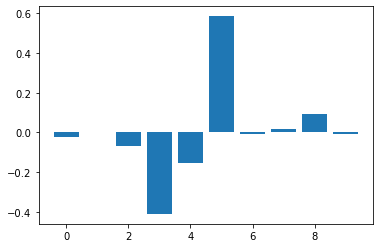

                                   OLS Regression Results                                  
Dep. Variable:     delivery_duration_secs   R-squared (uncentered):                   0.115
Model:                                OLS   Adj. R-squared (uncentered):              0.115
Method:                     Least Squares   F-statistic:                              1510.
Date:                    Sat, 13 May 2023   Prob (F-statistic):                        0.00
Time:                            17:55:57   Log-Likelihood:                     -1.1878e+05
No. Observations:                  116533   AIC:                                  2.376e+05
Df Residuals:                      116523   BIC:                                  2.377e+05
Df Model:                              10                                                  
Covariance Type:                nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025

In [34]:
delivery_time_reg(updated_df, ['market_id','store_id','create_hour','total_onshift_dashers', 'total_busy_dashers','total_outstanding_orders','min_item_price','max_item_price','subtotal','create_week'])

# KNN 

In [27]:
#prepare data for knn model 
def delivery_time_knn(data, groupby, k):
    y=data['delivery_duration_secs'].astype('int64')
    X=data[groupby]
    #Data partitioning into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=109)  

    scaler = StandardScaler()  
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test) 
    
    #KNN fit
    classifier = KNeighborsClassifier(n_neighbors=k)  
    knn = classifier.fit(X_train, y_train)

    ## predict test set  (out-sample)
    out_forecast = knn.predict(X_test)
    ## predict train set  (in-sample)
    in_forecast = knn.predict(X_train)

    score_nb = round(accuracy_score(out_forecast,y_test)*100,2)
    print("The accuracy score achieved using KNN is: "+str(score_lr)+" %")

    print(run_error_result(y_test, out_forecast,'Out-sample'))
    print(run_error_result(y_train, in_forecast,'In-sample'))

In [29]:
delivery_time_knn(updated_df, ['market_id','create_hour','total_onshift_dashers','total_busy_dashers','total_outstanding_orders'],2)

                 MAE       MSE      RMSE  R2_SCORE
Out-sample  0.456794  0.660305  0.812592 -0.297748
                MAE       MSE      RMSE  R2_SCORE
In-sample  0.327621  0.497911  0.705628  0.013939
